<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/03_0NoteBook/Machine_Learning/Tree_based/03-01-02-08-01-tree-based-models-bagging-grf-survival-forest-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.8.1 Survival Forest

A **Survival Forest** in the `{grf}` package in R is a specialized random forest model designed for analyzing right-censored survival data, estimating conditional survival functions, and supporting causal inference with survival outcomes. It extends the generalized random forest framework to handle survival analysis tasks, such as estimating the probability of survival past a given time point conditional on covariates, $(t, x) = P(T > t | X = x)$. Below, I’ll explain the Survival Forest in `{grf}`, compare it to Random Survival Forests in the `{randomForestSRC}` and `{DynForest}` packages, and highlight key differences in their design, functionality, and use cases.

## Overview

The `survival_forest()` function in the `{grf}` package trains a forest for right-censored survival data, focusing on estimating the **conditional survival function** $S(t, x)$, which represents the probability that the survival time $T$ exceeds time $t$ given covariates $X = x$. It is part of the Generalized Random Forests (GRF) framework, which emphasizes flexible, non-parametric estimation and inference, including support for causal survival analysis.




### Key Features

-   `Honest Estimation`: Reduces bias by separating data for splits and leaf estimates.[ ](https://rdrr.io/cran/grf/man/grf-package.html)
-   `Causal Survival Analysis`: Supports estimating heterogeneous treatment effects for survival outcomes using `causal_survival_forest()`.[ ](https://grf-labs.github.io/grf/)
-   `Missing Data`: Handles missing covariates via imputation methods.
-   `Statistical Inference`: Provides confidence intervals for survival function estimates and treatment effects.[ ](https://rdrr.io/cran/grf/man/grf-package.html)
-   `Non-Parametric`: Makes no distributional assumptions, suitable for complex survival data.


### How It Works

1.  Input Data:

  -   A feature matrix $X$ (covariates).
  -   A vector of observed times $Y$ (minimum of survival time and censoring time).
  -   A vector of censoring indicators $D$ (1 if the event is observed, 0 if censored).
  -   Parameters like `num.trees`, `honesty`, and `min.node.size`.

2.  Tree Construction

  -   Trees are grown using bootstrap samples and random feature selection, as in standard random forests.
  -   Splits are chosen to maximize heterogeneity in the survival function, using a criterion tailored for survival data (e.g., log-rank or related statistics).
  -   If `honesty = TRUE`, data is split into two subsets: one for building the tree structure and another for estimating survival functions in the leaves.

3.  Prediction

   -   For a new data point $x$, the forest estimates $S(t, x)$ by averaging survival function estimates across trees, based on the Kaplan-Meier estimator or similar methods within each leaf.

4.  Output

  -   Conditional survival function estimates for specified time points.
  -   Supports causal survival analysis (e.g., via `causal_survival_forest()` for heterogeneous treatment effects with censored data).
  -   Provides confidence intervals and variable importance measures.

### Use Case

-   Estimating conditional survival probabilities (e.g., patient survival given clinical features).
-   Causal inference with survival outcomes (e.g., treatment effects in clinical trials with censoring).


### Comparison of Survival Forest (`{grf}`), Random Survival Forest (`{randomForestSRC}`), and Dynamic Random Forest (`{DynForest}`)

| **Aspect** | **Survival Forest (`{grf}`)** | **Random Survival Forest (`{randomForestSRC}`)** | **Dynamic Random Forest (`{DynForest}`)** |
|-----------------|-----------------|---------------------|------------------|
| `Primary Focus` | Estimating conditional survival functions and causal effects. | General survival analysis with rich diagnostics. | Survival analysis with time-dependent covariates. |
| `Input Data` | Static covariates, right-censored survival data (`Y`, `D`). | Static covariates, `Surv(time, status)`. | Time-dependent covariates, longitudinal data. |
| `Splitting Criterion` | Heterogeneity in survival function (e.g., log-rank-based). | Log-rank, log-rank score, or random splitting. | Log-rank adapted for time-dependent covariates. |
| `Honest Estimation` | Supported (reduces bias). | Not explicitly supported. | Not explicitly supported. |
| `Causal Inference` | Strong support via `causal_survival_forest()`. | Limited (requires post-processing). | Not a primary focus. |
| `Time-Dependent Covariates` | Not supported. | Not supported. | Supported (core feature). |
| `Prediction Output` | Conditional survival function $S(t, x)$, treatment effects. | Survival curves, hazard functions, VIMP. | Dynamic survival curves, hazard functions. |
| `Statistical Inference` | Confidence intervals for survival and treatment effects. | Brier scores, VIMP, minimal depth. | Limited inference tools. |
| `Computational Efficiency` | Moderate (C++ backend, honest splitting). | High (OpenMP parallel processing). | Moderate (depends on longitudinal data complexity). |
| `*Diagnostics/Visualization` | Variable importance, limited plotting. | Rich diagnostics, integrates with `ggRandomForests`. | Limited, focused on dynamic effects. |
| `Use Case` | Causal survival analysis, conditional survival estimation. | General survival analysis, variable selection. | Longitudinal survival data, dynamic predictions. |

## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314972 sha256=1bc1dbf558968b10621a407d4b48a8d0e491fd72acb2bea2601aefef340e64d2
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Survival Forest with {grf} Package in R

This section demonstrates how to implement a Survival Forest using the `{grf}` package in R, focusing on the `lung` dataset from the `{survival}` package. The goal is to estimate conditional survival functions and evaluate model performance.






### Load and Check Required Libraries

In [4]:
%%R
packages <- c('tidyverse',
              'plyr',
              'grf',
              'survival',
              'mlbench',
              'Metrics')

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [6]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
tidyverse      plyr       grf  survival   mlbench   Metrics 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [7]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))


### Check Loaded Packages

In [8]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:Metrics"   "package:mlbench"   "package:survival" 
 [4] "package:grf"       "package:plyr"      "package:lubridate"
 [7] "package:forcats"   "package:stringr"   "package:dplyr"    
[10] "package:purrr"     "package:readr"     "package:tidyr"    
[13] "package:tibble"    "package:ggplot2"   "package:tidyverse"
[16] "package:tools"     "package:stats"     "package:graphics" 
[19] "package:grDevices" "package:utils"     "package:datasets" 
[22] "package:methods"   "package:base"     


### Load and Explore the Lung Dataset

The `lung` dataset contains survival data for 228 patients with advanced lung cancer.

In [10]:
%%R
# Load the lung dataset
data(lung, package = "survival")
# Check for NAs in key variables
cat("NAs in time:", sum(is.na(lung$time)), "\n")
cat("NAs in status:", sum(is.na(lung$status)), "\n")

NAs in time: 0 
NAs in status: 0 


### Prepare the Data

Rows after removing NAs: 168 
Number of events (D=1):
D
  0   1 
 47 121 
Summary of event times where event observed:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    5.0   147.0   246.0   289.1   426.0   814.0 
Using horizon = 814 


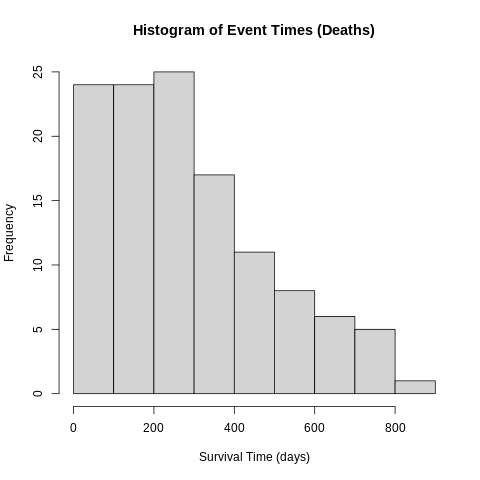

In [11]:
%%R
# Clean and recode variables
# Choose covariates and remove rows with missing values in any relevant variable
covar_names <- c("age", "ph.ecog", "ph.karno", "pat.karno", "meal.cal", "wt.loss")
lung2 <- lung[complete.cases(lung[, c("time", "status", "sex", covar_names)]), ]
cat("Rows after removing NAs:", nrow(lung2), "\n")

# Prepare variables for grf
Y <- lung2$time
D <- ifelse(lung2$status == 2, 1, 0)   # 1=event(death), 0=censored
W <- ifelse(lung2$sex == 2, 1, 0)      # 1=female, 0=male (treatment: female)
X <- as.matrix(lung2[, covar_names])

# Check distribution of events and event times
cat("Number of events (D=1):\n")
print(table(D))
cat("Summary of event times where event observed:\n")
print(summary(Y[D == 1]))
hist(Y[D == 1], main="Histogram of Event Times (Deaths)", xlab="Survival Time (days)")

# Find a valid horizon (latest time with at least one event)
event_times <- sort(unique(Y[D == 1]))
for (ht in event_times) {
  n_events <- sum(D == 1 & Y <= ht)
  if (n_events > 0) {
    last_valid_ht <- ht
  }
}
cat("Using horizon =", last_valid_ht, "\n")

### Split Data into Training and Test Sets

In [12]:
%%R
# Split data into training (80%) and test (20%) sets
train_prop <- 0.8
n <- nrow(lung2)
# train data
train_idx <- sample(1:n, size = round(train_prop * n))
X_train <- X[train_idx, , drop = FALSE]
Y_train <- Y[train_idx]
W_train <- W[train_idx]
D_train <- D[train_idx]
# test data
X_test <- X[-train_idx, , drop = FALSE]
Y_test <- Y[-train_idx]
W_test <- W[-train_idx]
D_test <- D[-train_idx]

cat("Training set size:", nrow(X_train), "\n")
cat("Test set size:", nrow(X_test), "\n")
cat("Column names of X_train:", colnames(X_train), "\n")

Training set size: 134 
Test set size: 34 
Column names of X_train: age ph.ecog ph.karno pat.karno meal.cal wt.loss 


### Train the Survival Forest

Survival forest in the `{grf}` package is trained using the `survival_forest()` function, which estimates the conditional survival function based on the training data.

In [13]:
%%R
# Train the survival forest
s_forest <- survival_forest(
  X = X_train,
  Y = Y_train,
  D = D_train,
  num.trees = 1000,
  sample.fraction = 0.5,
  mtry = min(ceiling(sqrt(ncol(X_train)) + 20), ncol(X_train)),
  min.node.size = 15,
  honesty = TRUE,
  honesty.fraction = 0.5,
  prediction.type = "Kaplan-Meier",
  compute.oob.predictions = TRUE,
  seed = 123
)
print(s_forest)

GRF forest object of type survival_forest 
Number of trees: 1000 
Number of training samples: 134 
Variable importance: 
    1     2     3     4     5     6 
0.304 0.070 0.110 0.190 0.188 0.138 


### Evaluate the Survival Forest

In [14]:
%%R
# Predict on test set
s_pred_test <- predict(s_forest, X_test, prediction.type = "Kaplan-Meier")

# Evaluate the model using out-of-bag (OOB) concordance
s_pred_oob <- predict(s_forest)  # OOB predictions
chf_score <- rowSums(-log(s_pred_oob$predictions))  # Mortality score
if (require("survival", quietly = TRUE)) {
  oob_concordance <- concordance(Surv(Y_train, D_train) ~ chf_score, reverse = TRUE)
  cat("OOB Concordance:", oob_concordance$concordance, "\n")
}

OOB Concordance: 0.5476608 


### Visualize Survival Curves

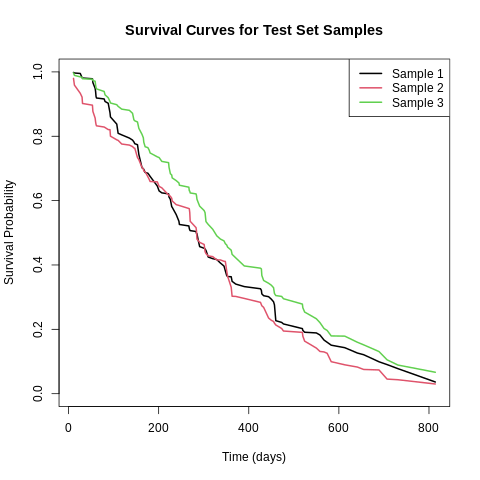

In [15]:
%%R
# Visualize survival curves for a few test samples
plot(NA, NA,
     xlab = "Time (days)",
     ylab = "Survival Probability",
     xlim = range(s_pred_test$failure.times),
     ylim = c(0, 1),
     main = "Survival Curves for Test Set Samples")
for (i in 1:min(3, nrow(X_test))) {
  lines(s_pred_test$failure.times, s_pred_test$predictions[i, ], col = i, lwd = 2)
}
legend("topright", legend = paste("Sample", 1:min(3, nrow(X_test))), col = 1:min(3, nrow(X_test)), lwd = 2)


### Compute Median Survival Time

In [16]:
%%R
# Compute median survival time for test set predictions
median_survival <- apply(s_pred_test$predictions, 1, function(s) {
  times <- s_pred_test$failure.times
  times[which(s <= 0.5)[1]]  # First time where survival probability <= 0.5
})
cat("Median survival times for test set (first 5 samples):\n", head(median_survival, 5), "\n")

Median survival times for test set (first 5 samples):
 284 285 329 267 345 


## Summary and Conclusion

Survial forest in {grf} package is a powerful tool for analyzing right-censored survival data, estimating conditional survival functions, and supporting causal inference. It extends the generalized random forest framework to handle survival analysis tasks, such as estimating the probability of survival past a given time point conditional on covariates. The model is particularly useful in medical research, clinical trials, and other fields where survival outcomes are of interest.


## References

1.  Cui, Yifan, Michael R. Kosorok, Erik Sverdrup, Stefan Wager, and Ruoqing Zhu. "Estimating Heterogeneous Treatment Effects with Right-Censored Data via Causal Survival Forests." Journal of the Royal Statistical Society: Series B, 85(2), 2023.

2.  Ishwaran, Hemant, Udaya B. Kogalur, Eugene H. Blackstone, and Michael S. Lauer. "Random survival forests." The Annals of Applied Statistics 2.3 (2008): 841-860.

3.  [Survival forest](hhttps://grf-labs.github.io/grf/reference/survival_forest.html#arguments)
